**PROJECT TEAM ID**: PTID-CDS-DEC-23-1715  
**PROJECT CODE**   : PRCP-1001-RiceLeaf  
**PROJECT NAME**   : Rice Leaf Disease using CNN

## Business Case

Our company, AgriTech Solutions, specializes in leveraging cutting-edge technology to improve agricultural practices. We are currently working on a project to enhance the monitoring and early detection of diseases affecting rice crops. This project aims to provide farmers with a reliable tool that can quickly identify and classify common diseases such as leaf blast, bacterial blight, and brown spot in rice plants.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 423
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Ds Projects/RiceLeaf disease detection/Data set",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [ ]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 423, 423, 3)
[0 1 2 2 1 0 1 0 1 1 1 2 0 1 0 1 1 1 0 0 2 2 1 2 1 1 1 2 0 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

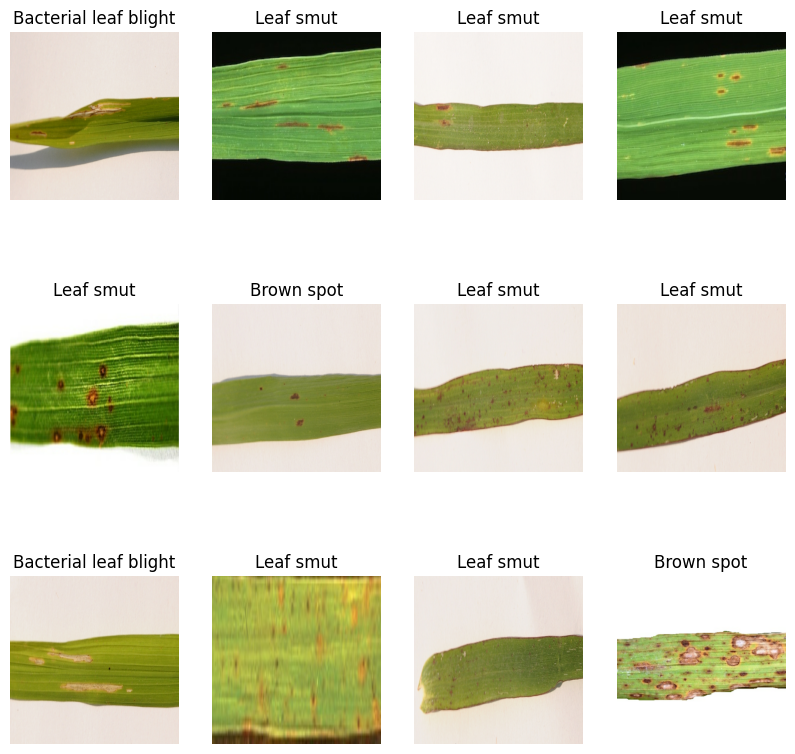

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

4

In [ ]:
train_size = 0.8
len(dataset)*train_size

3.2

In [ ]:
train_ds = dataset.take(3)
len(train_ds)

3

In [ ]:
test_ds = dataset.skip(3)
len(test_ds)

1

In [ ]:
val_size=0.1
len(dataset)*val_size

0.4

In [ ]:
val_ds = train_ds.take(1)
len(val_ds)

1

In [ ]:
len(train_ds)

3

In [ ]:
len(val_ds)

1

In [ ]:
len(test_ds)

1

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 423, 423, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 421, 421, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 210, 210, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 208, 208, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 104, 104, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 102, 102, 64)       

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 49s 16s/step - loss: 1.1128 - accuracy: 0.3125 - val_loss: 1.0939 - val_accuracy: 0.4375
Epoch 2/50
3/3 [==============================] - 44s 15s/step - loss: 1.0995 - accuracy: 0.3438 - val_loss: 1.0941 - val_accuracy: 0.4375
Epoch 3/50
3/3 [==============================] - 45s 14s/step - loss: 1.0991 - accuracy: 0.3438 - val_loss: 1.0923 - val_accuracy: 0.4375
Epoch 4/50
3/3 [==============================] - 43s 14s/step - loss: 1.0979 - accuracy: 0.3438 - val_loss: 1.0931 - val_accuracy: 0.4375
Epoch 5/50
3/3 [==============================] - 42s 15s/step - loss: 1.0979 - accuracy: 0.3438 - val_loss: 1.0902 - val_accuracy: 0.4375
Epoch 6/50
3/3 [==============================] - 53s 16s/step - loss: 1.0969 - accuracy: 0.3438 - val_loss: 1.0877 - val_accuracy: 0.4375
Epoch 7/50
3/3 [==============================] - 47s 15s/step - loss: 1.0969 - accuracy: 0.3438 - val_loss: 1.0843 - val_accuracy: 0.4375
Epoch 8/50
3/3 [===========

In [ ]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 4s 4s/step - loss: 0.2692 - accuracy: 0.8696


**You can see above that we get 86.96% accuracy for our test dataset. This is considered to be a good accuracy**

In [ ]:
scores

[0.2692221701145172, 0.8695651888847351]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 3}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][-5:]# show loss for last 5 epochs

[0.34243226051330566,
 0.3802219331264496,
 0.32506024837493896,
 0.36198821663856506,
 0.3292030990123749]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

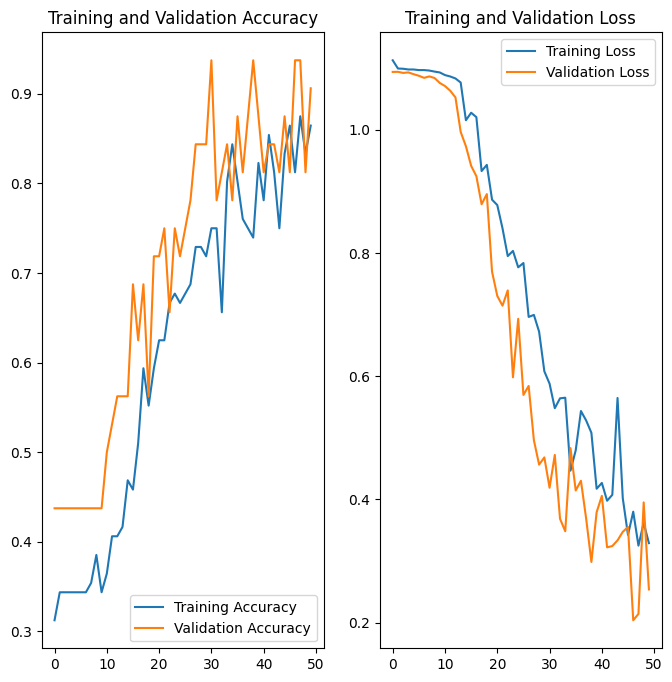

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Bacterial leaf blight
1/1 [==============================] - 2s 2s/step
predicted label: Bacterial leaf blight


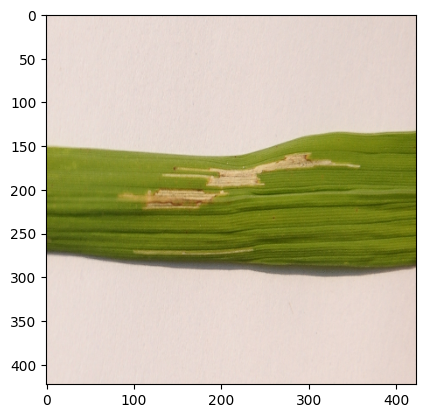

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 99ms/step


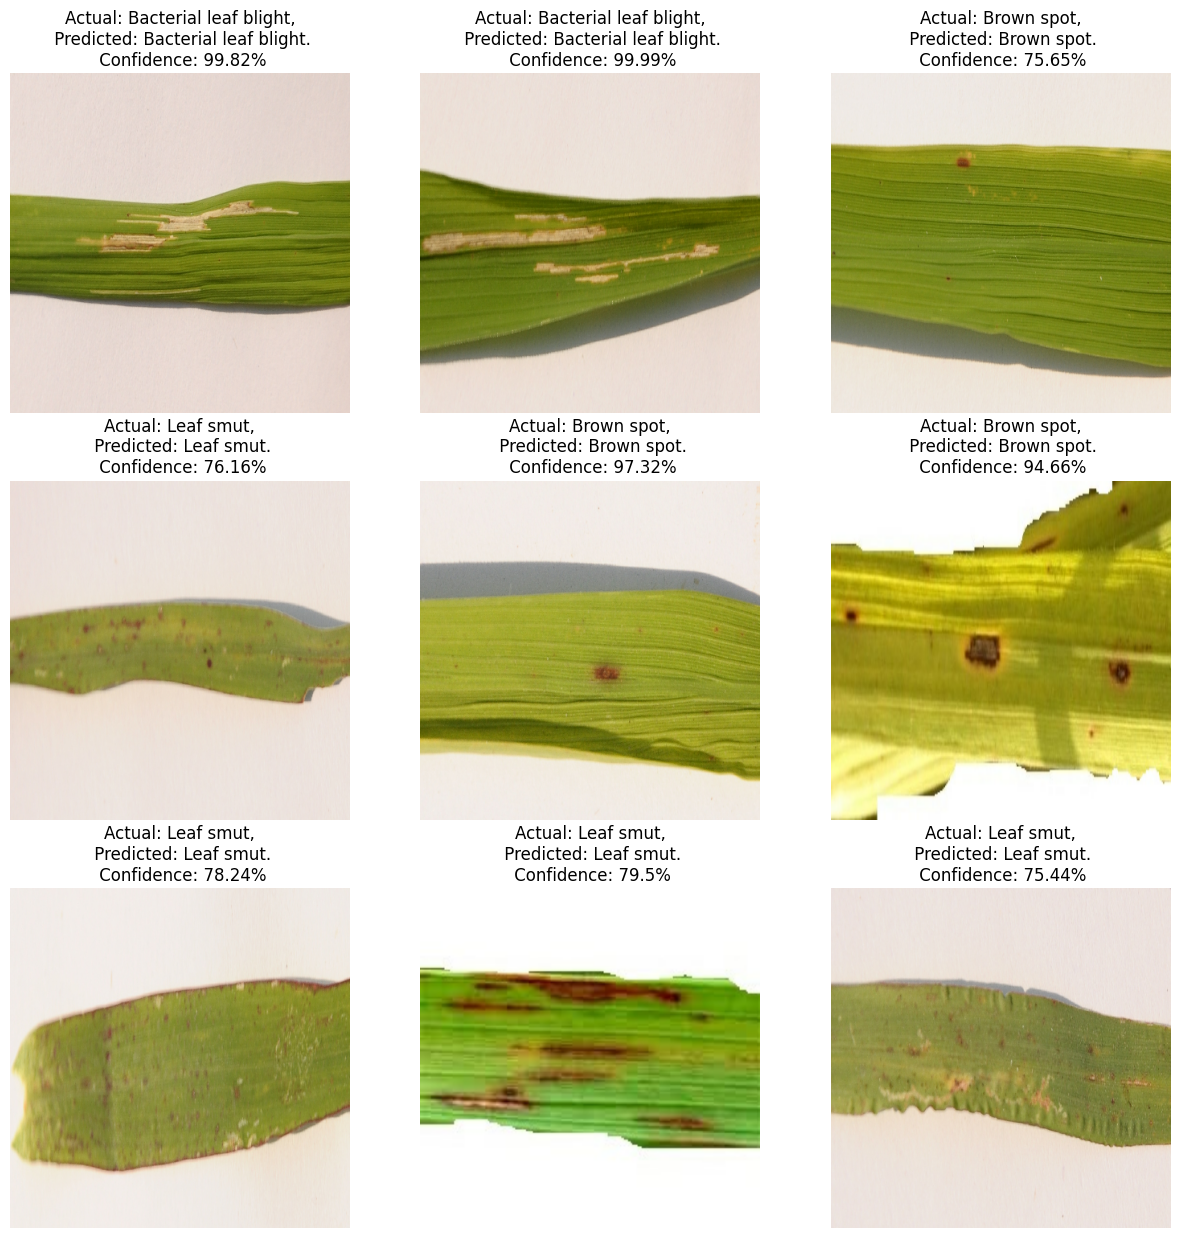

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Conlusion

By successfully implementing this project, AgriTech Solutions aims to make a positive impact on rice farming practices, empowering farmers with advanced technology to improve crop health and overall yield. This not only aligns with our company's mission but also contributes to sustainable and efficient agricultural practices.